In [1]:
import numpy as np
import itertools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Lasso, RidgeClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

np.set_printoptions(precision=3)
np.random.seed(42)

In [2]:
def plot_confusion_matrix(axis, cm, classes, 
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    im = axis.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    axis.set(title=title, xlabel='Predicted label', ylabel='True label')
    tick_marks = np.arange(len(classes))
    axis.set_xticks(tick_marks)
    axis.set_xticklabels(classes)
    axis.set_yticks(tick_marks)
    axis.set_yticklabels(classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        axis.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    return im


In [3]:
labels = np.genfromtxt('labels_for_microarray_data.csv', delimiter=",", skip_header=1)
dataset = np.genfromtxt('microarray_data.csv', delimiter=",", skip_header=1)[:, 1:].T
print(labels.shape, dataset.shape)

(969,) (969, 12179)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.25, shuffle = True)
print("Train and test sizes: {} {}".format(X_train.shape, X_test.shape))
print("(1, 0) labels count in train test: {} {}".format((np.count_nonzero(y_train==1), np.count_nonzero(y_train==0)), 
                                                        (np.count_nonzero(y_test==1), np.count_nonzero(y_test==0))))
class_names = np.array(["No event", "Met event"])
standarizer = StandardScaler().fit(X_train)
X_std_train = standarizer.transform(X_train)
X_std_test = standarizer.transform(X_test)

Train and test sizes: (726, 12179) (243, 12179)
(1, 0) labels count in train test: (289, 437) (104, 139)


In [9]:
def fit_clf(clf, train_set, train_labels, test_set, test_labels):
    clf = clf.fit(train_set, train_labels)
    print("Train and test scores: {} {}".format(clf.score(train_set, train_labels), clf.score(test_set, test_labels)))
    plot_clf(clf, train_set, train_labels, test_set, test_labels)
    return clf

def plot_clf(clf, train_set, train_labels, test_set, test_labels):
    test_labels_pred = clf.predict(test_set)
    train_labels_pred = clf.predict(train_set)
    test_cm = confusion_matrix(test_labels, test_labels_pred)
    train_cm = confusion_matrix(train_labels, train_labels_pred)
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True) 
    im = plot_confusion_matrix(ax1, test_cm, classes=class_names, normalize=True, title='Test confusion matrix')
    im = plot_confusion_matrix(ax2, train_cm, classes=class_names, normalize=True, title="Train confusion matrix")
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    plt.show()

Train and test scores: 0.9655647382920111 0.7695473251028807


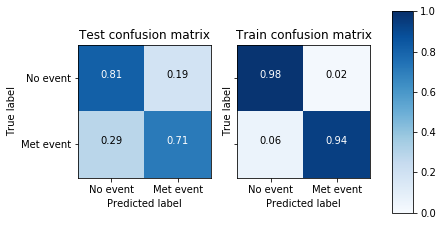

Train and test scores: 0.931129476584022 0.7489711934156379


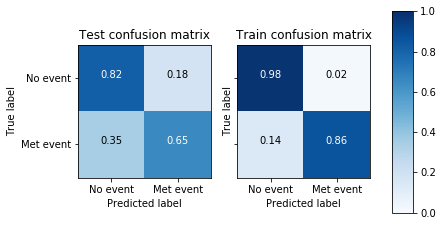

Train and test scores: 0.8457300275482094 0.6337448559670782


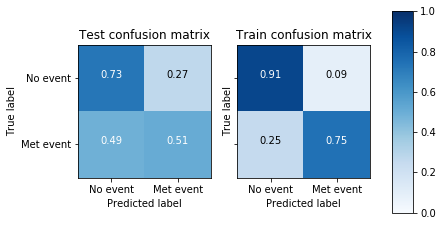

Train and test scores: 0.8705234159779615 0.6995884773662552


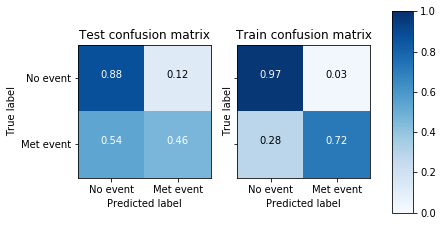

In [10]:
clf_logit = fit_clf(LogisticRegression(solver='liblinear', penalty='l1', C=0.3), X_train, y_train, X_test, y_test)
clf_svm = fit_clf(SVC(gamma='scale', C=7), X_train, y_train, X_test, y_test)
clf_tree = fit_clf(DecisionTreeClassifier(max_depth=4, min_samples_leaf=10), X_train, y_train, X_test, y_test)
clf_forest = fit_clf(RandomForestClassifier(max_depth=4, n_estimators=100, min_samples_leaf=10), X_train, y_train, X_test, y_test)

Train and test scores: 1.0 0.7366255144032922


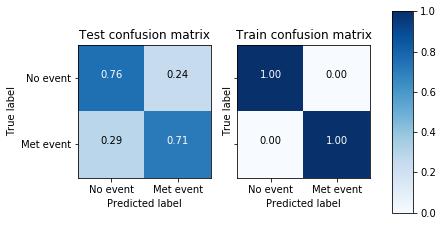

Train and test scores: 1.0 0.7448559670781894


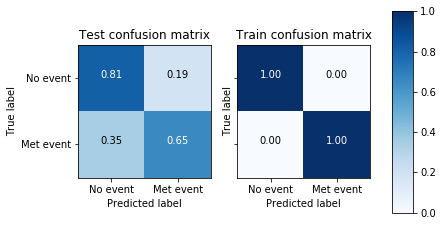

Train and test scores: 0.8457300275482094 0.6378600823045267


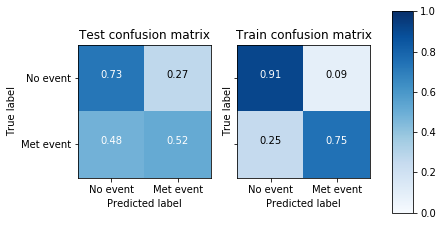

Train and test scores: 0.8787878787878788 0.7119341563786008


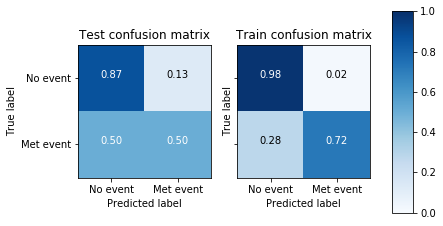

In [39]:
clf_logit = fit_clf(LogisticRegression(solver='liblinear', penalty='l1', C=0.3), X_std_train, y_train, X_std_test, y_test)
clf_svm = fit_clf(SVC(gamma='scale', C=7), X_std_train, y_train, X_std_test, y_test)
clf_tree = fit_clf(DecisionTreeClassifier(max_depth=4, min_samples_leaf=10), X_std_train, y_train, X_std_test, y_test)
clf_forest = fit_clf(RandomForestClassifier(max_depth=4, n_estimators=100, min_samples_leaf=10), X_std_train, y_train, X_std_test, y_test)

In [50]:
#test thresholding for loogit regression
threshold = 0.1
preds_train = np.array([1 if x > threshold else 0 for x in clf_logit.predict_proba(X_std_train)[:,1]])
preds_test = np.array([1 if x > threshold else 0 for x in clf_logit.predict_proba(X_std_test)[:,1]])
cm_train = confusion_matrix(y_train, preds_train)
cm_train = cm_train.astype('float') / cm_train.sum(axis=1)[:, np.newaxis]
cm_test = confusion_matrix(y_test, preds_test)
cm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
print(cm_train)
print(cm_test)

[[0.776 0.224]
 [0.    1.   ]]
[[0.475 0.525]
 [0.135 0.865]]
